## Datasets

### QM9

In [2]:
# load qm9 dataset
import pickle
import numpy as np

with open('data/qm9_test_nx.pkl', 'rb') as f:
    qm9 = pickle.load(f)

with open('data/zinc250k_test_nx.pkl', 'rb') as f:
    zinc = pickle.load(f)

In [13]:
# examine the networkx graph
print(qm9[0].nodes(data=True))
print(qm9[0].edges(data=True))

# extract node features

[(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'O'}), (3, {'label': 'C'}), (4, {'label': 'O'}), (5, {'label': 'C'}), (6, {'label': 'C'}), (7, {'label': 'N'})]
[(0, 1, {'label': 1}), (1, 2, {'label': 1}), (1, 3, {'label': 1}), (3, 4, {'label': 1}), (3, 5, {'label': 1}), (5, 6, {'label': 1}), (6, 7, {'label': 3})]


In [31]:
# visualize the first molecule
import networkx as nx
import matplotlib.pyplot as plt

mol0 = qm9[0]
print(mol0)
# nodes attributes
print("Node attributes:")
for n, d in mol0.nodes(data=True):
    print(n, d)
    
print("Edge attributes:")
for u, v, d in mol0.edges(data=True):
    print(u, v, d)


Graph with 8 nodes and 7 edges
Node attributes:
0 {'label': 'C'}
1 {'label': 'C'}
2 {'label': 'O'}
3 {'label': 'C'}
4 {'label': 'O'}
5 {'label': 'C'}
6 {'label': 'C'}
7 {'label': 'N'}
Edge attributes:
0 1 {'label': 1}
1 2 {'label': 1}
1 3 {'label': 1}
3 4 {'label': 1}
3 5 {'label': 1}
5 6 {'label': 1}
6 7 {'label': 3}


## Skeleton-Preserving Lifting Map

__Definition (k-skeleton).__ A $k$-skeleton of a cell complex $\mathcal{C}$, denoted $\mathcal{C}^{(k)}$, is the subcomplex of $\mathcal{C}$ consisting of cells of dimension at most $k$.

__Definition (Skeleton-Preserving Cellular Lifting Map).__ A cellular lifting map $s: \mathcal{G} \rightarrow \mathcal{C}_{\mathcal{G}}$ is a skeleton preserving function that incorporates a graph $\mathcal{G}$ into a regular cell complex $\mathcal{C}_{\mathcal{G}}$, such that, for any graph $\mathcal{G}$, the 1 -skeleton (i.e., the underlying graph) of $s(\mathcal{G})$ and $\mathcal{G}$ are isomorphic.


In [6]:
# load zinc rings
with open('data/qm9_test_rings.pkl', 'rb') as f:
    qm9_rings = pickle.load(f)

In [7]:
from toponetx.classes.cell_complex import CellComplex

# create a cell complex from the first molecule
qm_mol = qm9[10]
qm_mol_rings = qm9_rings[10]
cell_complex = CellComplex(qm_mol)

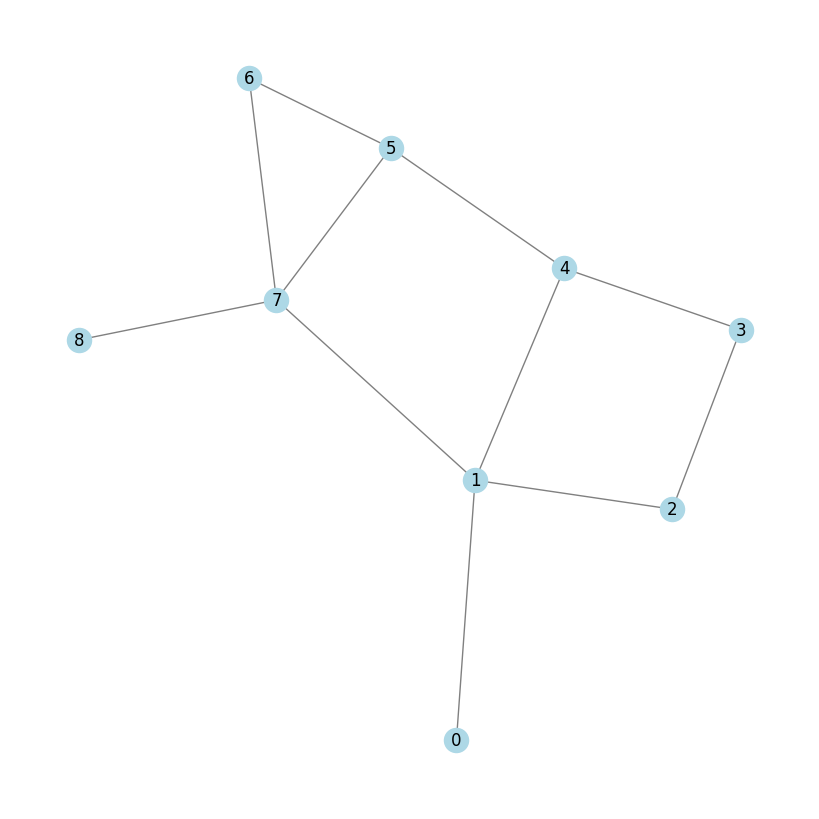

In [14]:
nx.draw(qm_mol, with_labels=True, node_color="lightblue", edge_color="gray")

In [10]:
cell_complex.add_cells_from(qm_mol_rings, rank=2)

In [55]:
print(cell_complex)

Cell Complex with 9 nodes, 11 edges and 3 2-cells 


In [56]:
row, column, incidence_2 = cell_complex.incidence_matrix(rank=2, index=True)
print("edges:")
print(row)
print("2-cells:")
print(column)

edges:
{(0, 1): 0, (1, 2): 1, (1, 4): 2, (1, 7): 3, (2, 3): 4, (3, 4): 5, (4, 5): 6, (5, 6): 7, (5, 7): 8, (6, 7): 9, (7, 8): 10}
2-cells:
{(5, 6, 7): 0, (1, 2, 3, 4): 1, (1, 4, 5, 7): 2}


In [30]:
cell_complex.node_to_all_cell_adjacnecy_matrix().todense()

matrix([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 2., 1., 3., 1., 0., 2., 0.],
        [0., 2., 0., 2., 1., 0., 0., 0., 0.],
        [0., 1., 2., 0., 2., 0., 0., 0., 0.],
        [0., 3., 1., 2., 0., 2., 0., 1., 0.],
        [0., 1., 0., 0., 2., 0., 2., 3., 0.],
        [0., 0., 0., 0., 0., 2., 0., 2., 0.],
        [0., 2., 0., 0., 1., 3., 2., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])

## Prepare the Neighborhood Structure for CAN

In [12]:
# normal node adjacency matrix
adj_0 = cell_complex.adjacency_matrix(rank=0).todense()
print(adj_0)

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


For lower neighborhood, rank should be larger than 0 and <= 2.

In [13]:
# lower neighborhood 
lower_neighborhood_1 = cell_complex.down_laplacian_matrix(rank=1)
lower_neighborhood_2 = cell_complex.down_laplacian_matrix(rank=2)
print(lower_neighborhood_1.todense())
print(lower_neighborhood_2.todense())

[[ 2. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2.  1.  1. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  2.  1.  0.  1. -1.  0.  0.  0.  0.]
 [-1.  1.  1.  2.  0.  0.  0.  0.  1.  1. -1.]
 [ 0. -1.  0.  0.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  2. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.  1. -1.  0.]
 [ 0.  0.  0.  1.  0.  0. -1.  1.  2.  1. -1.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.  1.  2. -1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0. -1. -1.  2.]]
[[ 3.  0. -1.]
 [ 0.  4. -1.]
 [-1. -1.  4.]]


Rank should larger than 0 and <= 1 (maximal dimension cells-1), got 2.

In [55]:
# upper neighborhood
upper_neighborhood_1 = cell_complex.up_laplacian_matrix(rank=0)
upper_neighborhood_2 = cell_complex.up_laplacian_matrix(rank=1)

print(upper_neighborhood_1.todense())
print(upper_neighborhood_2.todense())

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0. -1.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  3. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0. -1.  0.  0.  0. -1. -1.  4. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1. -1. -1.  1.  0.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.  0. -1.  0. -1.  0.  0.]
 [ 0.  1. -1.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  1.  0.]
 [ 0.  0.  1. -1.  0.  0.  1. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Load Data before Training

In [2]:
from utils.data_loader_mol import load_mol
import os
import json

# load zinc dataset
qm9_mols = load_mol('data/qm9_kekulized.npz')

with open('data/valid_idx_qm9.json') as f:
        test_idx = json.load(f)

test_idx = test_idx['valid_idxs']
test_idx = [int(i) for i in test_idx]
train_idx = [i for i in range(len(qm9_mols)) if i not in test_idx]

Loading file data/qm9_kekulized.npz


In [3]:
print(f'Number of training mols: {len(train_idx)} | Number of test mols: {len(test_idx)}')

Number of training mols: 120803 | Number of test mols: 13082


In [4]:
train_mols = [qm9_mols[i] for i in train_idx]
test_mols = [qm9_mols[i] for i in test_idx]

In [26]:
x, adj = train_mols[4]

print(x.shape)
print(adj.shape)

(9,)
(4, 9, 9)


In [6]:
from utils.data_loader_mol import MolDataset, get_transform_fn
train_dataset = MolDataset(train_mols, get_transform_fn('QM9'))
test_dataset = MolDataset(test_mols, get_transform_fn('QM9'))

In [7]:
len(train_dataset), len(test_dataset)

(120803, 13082)

In [23]:
train_dataset[2][0].shape

torch.Size([9, 4])

In [10]:
import networkx as nx
import numpy as np
train_mols_nx = [nx.from_numpy_matrix(np.array(adj)) for x, adj in train_dataset]
test_mols_nx = [nx.from_numpy_matrix(np.array(adj)) for x, adj in test_dataset]

In [16]:
train_mols_nx[4].nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}})